In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.metrics import accuracy_score, classification_report

# Specify dataset paths
train_path = '/kaggle/input/gujarati-language-hand-signs/data/train'
test_path = '/kaggle/input/gujarati-language-hand-signs/data/test'

# Define class labels
classes = {
    'ka': 0, 'kha': 1, 'ga': 2, 'gha': 3, 'cha': 4, 'chha': 5, 'ja': 6, 'za': 7, 'ta': 8, 'tha': 9,
    'dda': 10, 'dhha': 11, 'nna': 12, 'ta': 13, 'tha': 14, 'da': 15, 'dha': 16, 'na': 17, 'pa': 18,
    'fa': 19, 'ba': 20, 'bha': 21, 'ma': 22, 'ya': 23, 'ra': 24, 'la': 25, 'va': 26, 'sha': 27,
    'sh': 28, 'sa': 29, 'ha': 30, 'lla': 31, 'ksha': 32, 'gna': 33
}

# Load and preprocess images
X = []
Y = []

for cls in classes:
    class_path = os.path.join(train_path, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image in color (VGG expects 3 channels)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224 pixels as required by VGG19
        X.append(img)
        Y.append(classes[cls])

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Normalize data
X = X / 255.0  # Normalize pixel values to range [0, 1]

# One-hot encode labels
lb = LabelBinarizer()
Y = lb.fit_transform(Y)

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=42)


In [8]:
# Load VGG19 model with pre-trained ImageNet weights, excluding the top layer
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [9]:
# Freeze the layers of VGG19 to retain the pre-trained weights
for layer in vgg19_base.layers:
    layer.trainable = False


In [10]:
# Add custom layers on top of the VGG19 base
model = Sequential([
    vgg19_base,
    Flatten(),  # Flatten the output from VGG19
    Dense(256, activation='relu'),  # Add a fully connected layer
    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(len(classes), activation='softmax')  # Output layer for multi-class classification
])

In [11]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [12]:
# Train the model
vgg19_history = model.fit(
    xtrain, ytrain,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 298ms/step - accuracy: 0.0520 - loss: 3.5992 - val_accuracy: 0.2854 - val_loss: 3.0848
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.1834 - loss: 2.9928 - val_accuracy: 0.4271 - val_loss: 2.6145
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3610 - loss: 2.4890 - val_accuracy: 0.6008 - val_loss: 2.2035
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4821 - loss: 2.1080 - val_accuracy: 0.6627 - val_loss: 1.8591
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.6058 - loss: 1.7865 - val_accuracy: 0.7106 - val_loss: 1.6045
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.6769 - loss: 1.4979 - val_accuracy: 0.7405 - val_loss: 1.4433
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7389 - loss: 1.2666 - val_accuracy: 0.7764 - val_loss: 1.2977
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7571 - loss: 1.1191 - val_accuracy: 0

In [13]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(xtrain, ytrain)
test_loss, test_accuracy = model.evaluate(xtest, ytest)
print(f"VGG19 Training Accuracy: {train_accuracy}")
print(f"VGG19 Testing Accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9560 - loss: 0.2227
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8724 - loss: 0.5505
VGG19 Training Accuracy: 0.9428228735923767
VGG19 Testing Accuracy: 0.8723205924034119


In [14]:
# Predict on test data
y_pred = model.predict(xtest)
y_pred_classes = np.argmax(y_pred, axis=1)
ytest_classes = np.argmax(ytest, axis=1)

# Print the classification report
print("Classification Report:\n", classification_report(ytest_classes, y_pred_classes))


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.80        38
           1       1.00      0.97      0.99        40
           2       0.95      0.84      0.89        43
           3       0.97      0.97      0.97        36
           4       0.95      0.90      0.92        39
           5       1.00      0.97      0.99        36
           6       0.88      0.94      0.91        32
           7       0.89      0.94      0.92        36
           8       0.91      0.91      0.91        34
           9       0.89      1.00      0.94        25
          10       0.92      0.97      0.94        35
          11       0.82      0.88      0.85        32
          12       0.92      0.79      0.85        43
          13       0.93      0.93      0.93        27
          14       1.00      1.00      1.00        30
          15       0.71      1.00      0.83        29
          16     

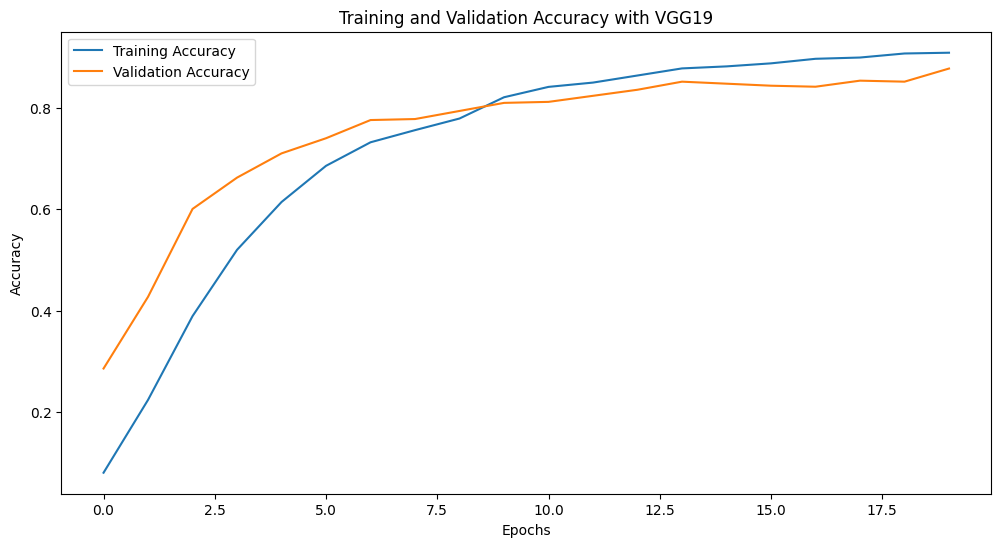

In [15]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(vgg19_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg19_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with VGG19')
plt.legend()
plt.show()

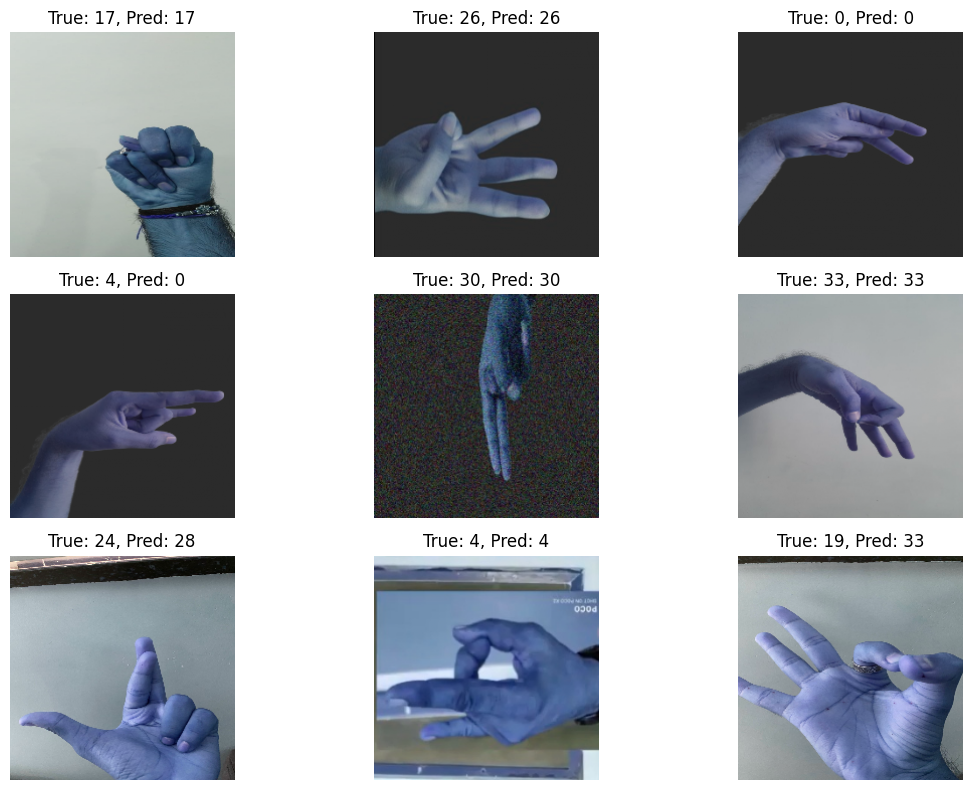

In [16]:
# Visualize some test predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(xtest[i])
    plt.title(f"True: {lb.classes_[ytest_classes[i]]}, Pred: {lb.classes_[y_pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()